In [27]:
import numpy as np
from keras import backend as K
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten, Activation, Dropout, Input, Reshape, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.models import Model, Sequential

In [38]:
TRAIN_PATH = r"D:\State Farm Distracted Driver\imgs\train"
VALID_PATH = r"D:\State Farm Distracted Driver\imgs\valid"
TEST_PATH = r"D:\State Farm Distracted Driver\imgs\test"
LOG_PATH = r"D:\State Farm Distracted Driver\logs"
RESULTS_PATH = r"D:\State Farm Distracted Driver"
NUM_CLASSES = 8
BATCH_SIZE = 20
IMAGE_SIZE = (224, 224)
FREEZE_LAYERS = 145
NUM_EPOCHS = 10
MODEL_DESCRIPTION = "First Attempt.h5"

In [39]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  channel_shift_range=10,
                                  horizontal_flip=True,
                                  fill_mode = 'nearest')

train_batches = train_datagen.flow_from_directory(TRAIN_PATH, 
                                                  target_size=IMAGE_SIZE,
                                                  interpolation = 'bicubic',
                                                  class_mode = 'categorical',
                                                  shuffle=True, batch_size = BATCH_SIZE)

Found 20824 images belonging to 8 classes.


In [40]:
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  channel_shift_range=10,
                                  horizontal_flip=True,
                                  fill_mode = 'nearest')

valid_batches = valid_datagen.flow_from_directory(VALID_PATH, 
                                                  target_size=IMAGE_SIZE,
                                                  interpolation = 'bicubic',
                                                  class_mode = 'categorical',
                                                  shuffle=True, batch_size = BATCH_SIZE)

Found 1600 images belonging to 8 classes.


[0. 0. 0. 0. 1. 0. 0. 0.]


(-0.5, 223.5, 223.5, -0.5)

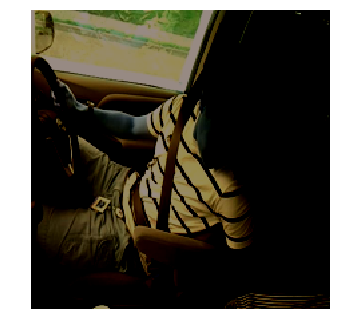

In [31]:
imgs, labels = next(train_batches)
print (labels[0])
plt.imshow((imgs[0]/255).clip(0,1)) # divide by 255, clip to between 0,1, and remove all preprocessing to see the original images
plt.axis('off')

In [41]:
net = ResNet50(include_top = False, weights = 'imagenet', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = net.output
x = Dropout(0.9)(x)
x = Flatten()(x)
output_layer = Dense(NUM_CLASSES, activation = 'softmax')(x)
CNN = Model(inputs=net.input, outputs=output_layer)
for layer in CNN.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in CNN.layers[FREEZE_LAYERS:]:
    layer.trainable = True
CNN.compile(optimizer=Adam(lr=1e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(CNN.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:
#tensorboard = TensorBoard(log_dir = LOG_PATH)

In [42]:
class TrainingPlot(Callback):
    def __init__(self, filename = "plot.jpg"):
        self.filename = filename
        
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []
        #self.val_losses = []
        #self.val_acc = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        #self.val_losses.append(logs.get('val_loss'))
        #self.val_acc.append(logs.get('val_acc'))
        
        if len(self.losses) == NUM_EPOCHS:
            N = np.arange(0, len(self.losses))
            plt.style.use("seaborn")
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            #plt.plot(N, self.val_losses, label = "val_loss")
            #plt.plot(N, self.val_acc, label = "val_acc")
            plt.xlabel("Epochs")
            plt.ylabel("Loss / Accuracy")
            plt.title(self.filename)
            plt.savefig(RESULTS_PATH + '/results/' + self.filename + ".jpg")
            plt.legend()
    
training_plot = TrainingPlot(MODEL_DESCRIPTION)

Epoch 1/10
1041/1041 [==============================] - 189s 182ms/step - loss: 5.5565 - acc: 0.2892
Epoch 2/10
1041/1041 [==============================] - 185s 178ms/step - loss: 2.3002 - acc: 0.6011
Epoch 3/10
1041/1041 [==============================] - 185s 178ms/step - loss: 1.0668 - acc: 0.7844
Epoch 4/10
1041/1041 [==============================] - 186s 179ms/step - loss: 0.5943 - acc: 0.8728
Epoch 5/10
1041/1041 [==============================] - 185s 177ms/step - loss: 0.3524 - acc: 0.9215
Epoch 6/10
1041/1041 [==============================] - 186s 178ms/step - loss: 0.2319 - acc: 0.9473
Epoch 7/10
1041/1041 [==============================] - 185s 178ms/step - loss: 0.1782 - acc: 0.9593
Epoch 8/10
1041/1041 [==============================] - 186s 178ms/step - loss: 0.1266 - acc: 0.9702s - loss: 0.1273 - acc
Epoch 9/10
1041/1041 [==============================] - 185s 178ms/step - loss: 0.0957 - acc: 0.9762
Epoch 10/10
1041/1041 [==============================] - 186s 178ms/s

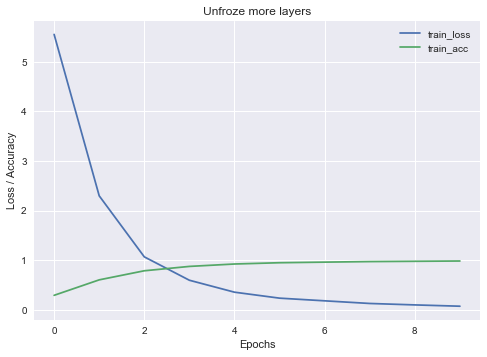

In [43]:
CNN.fit_generator(train_batches, 
                  steps_per_epoch = train_batches.samples // BATCH_SIZE, 
                  epochs = NUM_EPOCHS,
                  callbacks = [training_plot])

In [44]:
results = CNN.evaluate_generator(valid_batches, verbose=1)

80/80 [==============================] - 14s 177ms/step


In [45]:
print(results)

[0.4416419820860028, 0.8918749988079071]


In [26]:
print(CNN.metrics_names)

['loss', 'acc']
